In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val = df.copy()

# ensure numeric
val["years_since_review"] = pd.to_numeric(val["years_since_review"], errors="coerce")
val["NumberSubmitters_num"] = pd.to_numeric(val["NumberSubmitters_num"], errors="coerce")
val["conflicting"] = val["conflicting"].astype(bool)

# bins for staleness
bins = [0, 1, 2, 5, 10, 20, 50, 200]
labels = ["<1y", "1-2y", "2-5y", "5-10y", "10-20y", "20-50y", "50y+"]

val["ysr_bin"] = pd.cut(val["years_since_review"], bins=bins, labels=labels, include_lowest=True, right=False)

# simple groups
val["submitter_bin"] = pd.cut(
    val["NumberSubmitters_num"],
    bins=[-0.1, 1, 2, 5, 10, 10**9],
    labels=["1", "2", "3-5", "6-10", "11+"]
)

# summary table
sanity_tbl = pd.DataFrame({
    "group": [
        "conflicting = True",
        "conflicting = False",
        "single submitter (<=1)",
        "multi submitter (>=2)"
    ],
    "n": [
        int(val[val["conflicting"]].shape[0]),
        int(val[~val["conflicting"]].shape[0]),
        int(val[val["NumberSubmitters_num"] <= 1].shape[0]),
        int(val[val["NumberSubmitters_num"] >= 2].shape[0]),
    ],
    "mean_risk": [
        float(val.loc[val["conflicting"], "model_risk_proba"].mean()),
        float(val.loc[~val["conflicting"], "model_risk_proba"].mean()),
        float(val.loc[val["NumberSubmitters_num"] <= 1, "model_risk_proba"].mean()),
        float(val.loc[val["NumberSubmitters_num"] >= 2, "model_risk_proba"].mean()),
    ],
}).round(4)

sanity_path = OUT_TABLES / "validation_sanity_group_means.csv"
sanity_tbl.to_csv(sanity_path, index=False)

sanity_tbl, sanity_path


NameError: name 'df' is not defined

In [2]:
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "outputs").exists() and (p / "notebooks").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing 'outputs' and 'notebooks'.")

ROOT = find_repo_root(Path.cwd())
SCORED_PATH = ROOT / "outputs" / "phase4" / "tables" / "phase4_scored.csv.gz"
print("ROOT:", ROOT)
print("SCORED_PATH:", SCORED_PATH)

assert SCORED_PATH.exists(), f"Missing scored file: {SCORED_PATH}"
df = pd.read_csv(SCORED_PATH, compression="gzip", low_memory=False)
print("Loaded df:", df.shape)


ROOT: /Users/sanghati/research/accountable-interpretation
SCORED_PATH: /Users/sanghati/research/accountable-interpretation/outputs/phase4/tables/phase4_scored.csv.gz
Loaded df: (300000, 52)


In [3]:
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "outputs").exists() and (p / "notebooks").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing 'outputs' and 'notebooks'.")

ROOT = find_repo_root(Path.cwd())
SCORED_PATH = ROOT / "outputs" / "phase4" / "tables" / "phase4_scored.csv.gz"

print("ROOT:", ROOT)
print("SCORED_PATH:", SCORED_PATH)
assert SCORED_PATH.exists(), f"Missing scored file: {SCORED_PATH}"

df = pd.read_csv(SCORED_PATH, compression="gzip", low_memory=False)
print("Loaded df:", df.shape)


ROOT: /Users/sanghati/research/accountable-interpretation
SCORED_PATH: /Users/sanghati/research/accountable-interpretation/outputs/phase4/tables/phase4_scored.csv.gz
Loaded df: (300000, 52)


In [4]:
import numpy as np

tier_order = ["Low", "Moderate", "High", "Critical"]
df["model_risk_tier"] = pd.Categorical(df["model_risk_tier"], categories=tier_order, ordered=True)

val = df.copy()
val["years_since_review"] = pd.to_numeric(val["years_since_review"], errors="coerce")
val["NumberSubmitters_num"] = pd.to_numeric(val["NumberSubmitters_num"], errors="coerce")
val["conflicting"] = val["conflicting"].astype(bool)

val["is_single_submitter"] = val["NumberSubmitters_num"].le(1)
val["is_high_or_critical"] = val["model_risk_tier"].isin(["High", "Critical"])

OUT_DIR = ROOT / "outputs" / "phase5"
OUT_TABLES = OUT_DIR / "tables"
OUT_FIGS = OUT_DIR / "figures"
OUT_TABLES.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

sanity_tbl = pd.DataFrame([
    {"group": "conflicting=True", "n": int(val[val["conflicting"]].shape[0]),
     "mean_risk": float(val.loc[val["conflicting"], "model_risk_proba"].mean())},
    {"group": "conflicting=False", "n": int(val[~val["conflicting"]].shape[0]),
     "mean_risk": float(val.loc[~val["conflicting"], "model_risk_proba"].mean())},
    {"group": "single_submitter<=1", "n": int(val[val["is_single_submitter"]].shape[0]),
     "mean_risk": float(val.loc[val["is_single_submitter"], "model_risk_proba"].mean())},
    {"group": "multi_submitter>=2", "n": int(val[~val["is_single_submitter"]].shape[0]),
     "mean_risk": float(val.loc[~val["is_single_submitter"], "model_risk_proba"].mean())},
    {"group": "high_or_critical", "n": int(val[val["is_high_or_critical"]].shape[0]),
     "mean_risk": float(val.loc[val["is_high_or_critical"], "model_risk_proba"].mean())},
    {"group": "low_or_moderate", "n": int(val[~val["is_high_or_critical"]].shape[0]),
     "mean_risk": float(val.loc[~val["is_high_or_critical"], "model_risk_proba"].mean())},
]).round(4)

sanity_path = OUT_TABLES / "validation_sanity_group_means.csv"
sanity_tbl.to_csv(sanity_path, index=False)

sanity_tbl, sanity_path


(                 group       n  mean_risk
 0     conflicting=True   53539     0.1082
 1    conflicting=False  246461     0.3416
 2  single_submitter<=1   95356     0.5897
 3   multi_submitter>=2  204644     0.1650
 4     high_or_critical   83168     0.6723
 5      low_or_moderate  216832     0.1572,
 PosixPath('/Users/sanghati/research/accountable-interpretation/outputs/phase5/tables/validation_sanity_group_means.csv'))

/var/folders/7x/42f5r3c50870bwy_fq7n4v0m0000gn/T/ipykernel_20196/4052350295.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val.groupby("ysr_bin", dropna=False)


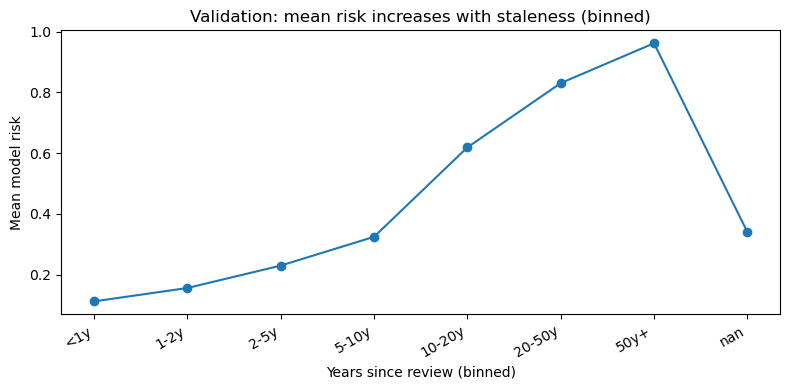

/var/folders/7x/42f5r3c50870bwy_fq7n4v0m0000gn/T/ipykernel_20196/4052350295.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val.groupby("submitter_bin", dropna=False)


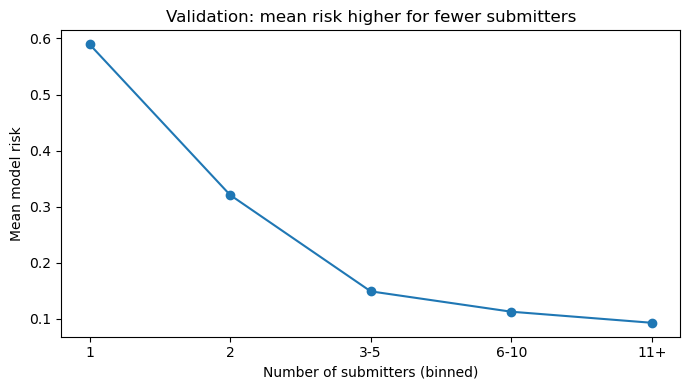

(PosixPath('/Users/sanghati/research/accountable-interpretation/outputs/phase5/figures/validation_mean_risk_by_staleness.png'),
 PosixPath('/Users/sanghati/research/accountable-interpretation/outputs/phase5/figures/validation_mean_risk_by_submitter_bin.png'))

In [5]:
import matplotlib.pyplot as plt

# staleness bins
bins = [0, 1, 2, 5, 10, 20, 50, 200]
labels = ["<1y", "1-2y", "2-5y", "5-10y", "10-20y", "20-50y", "50y+"]
val["ysr_bin"] = pd.cut(val["years_since_review"], bins=bins, labels=labels, include_lowest=True, right=False)

risk_by_ysr = (
    val.groupby("ysr_bin", dropna=False)
       .agg(n=("model_risk_proba","size"), mean_risk=("model_risk_proba","mean"))
       .reset_index()
)
risk_by_ysr.to_csv(OUT_TABLES / "validation_risk_by_staleness_bin.csv", index=False)

plt.figure(figsize=(8,4))
plt.plot(risk_by_ysr["ysr_bin"].astype(str), risk_by_ysr["mean_risk"], marker="o")
plt.title("Validation: mean risk increases with staleness (binned)")
plt.xlabel("Years since review (binned)")
plt.ylabel("Mean model risk")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
figA1 = OUT_FIGS / "validation_mean_risk_by_staleness.png"
plt.savefig(figA1, dpi=200)
plt.show()

# submitter bins
val["submitter_bin"] = pd.cut(val["NumberSubmitters_num"], bins=[-0.1,1,2,5,10,10**9], labels=["1","2","3-5","6-10","11+"])
risk_by_sub = (
    val.groupby("submitter_bin", dropna=False)
       .agg(n=("model_risk_proba","size"), mean_risk=("model_risk_proba","mean"))
       .reset_index()
)
risk_by_sub.to_csv(OUT_TABLES / "validation_risk_by_submitter_bin.csv", index=False)

plt.figure(figsize=(7,4))
plt.plot(risk_by_sub["submitter_bin"].astype(str), risk_by_sub["mean_risk"], marker="o")
plt.title("Validation: mean risk higher for fewer submitters")
plt.xlabel("Number of submitters (binned)")
plt.ylabel("Mean model risk")
plt.tight_layout()
figA2 = OUT_FIGS / "validation_mean_risk_by_submitter_bin.png"
plt.savefig(figA2, dpi=200)
plt.show()

figA1, figA2


In [7]:
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "outputs").exists() and (p / "notebooks").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing 'outputs' and 'notebooks'.")

ROOT = find_repo_root(Path.cwd())
SCORED_PATH = ROOT / "outputs" / "phase4" / "tables" / "phase4_scored.csv.gz"
print("ROOT:", ROOT)
print("SCORED_PATH:", SCORED_PATH)

assert SCORED_PATH.exists(), f"Missing scored file: {SCORED_PATH}"
df = pd.read_csv(SCORED_PATH, compression="gzip", low_memory=False)
print("Loaded df:", df.shape)


ROOT: /Users/sanghati/research/accountable-interpretation
SCORED_PATH: /Users/sanghati/research/accountable-interpretation/outputs/phase4/tables/phase4_scored.csv.gz
Loaded df: (300000, 52)


In [1]:
df["conflicting"].value_counts(dropna=False).head(10)


NameError: name 'df' is not defined

In [2]:
notebooks/05_clinvar_clinical_impact.ipynb


SyntaxError: invalid decimal literal (1133799368.py, line 1)